# Optimisation sous contraintes

Le but de ce notebook est de tester différents algorithmes d'optimisation sous contraintes dans un cas simple.

**Attention :** par souci de simplicité l'exemple choisi concerne la minimisation d'une fonction quadratique sous contraintes affines. Cela permet, lorsqu'on minimise sans contrainte cette fonction quadratique, ou son Lagrangien, de calculer directement le point de minimum en résolvant un système linéaire (ce qui est très facile). Bien sûr, dans le cas d'une fonction plus compliquée, il faudrait utiliser un algorithme de type gradient sans contrainte pour la minimiser (ce qui est plus coûteux en temps de calcul). Néanmoins, le but du TP est de voir le comportement des algorithmes (faisables, infaisables) et notamment comment la contrainte est satisfaite en pratique. Pour cela cet exemple simple est suffisant et... rapide. 


## Chargement des librairies utilisées

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from scipy import sparse
from scipy import optimize
from scipy.sparse.linalg import spsolve

## Mise en place du problème

On minimise la fonctionnelle quadratique $J: \mathbb R^N \rightarrow \mathbb R$ telle que  
$$ J(x) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle$$
sous la contrainte 
$$
B x = c
$$
avec une matrice $B$ de taille $M\times N$ et un vecteur $c\in \mathbb R^M$. 

On peut calculer la solution exacte en écrivant la condition d'optimalité. Il existe un multiplicateur de Lagrange $p\in \mathbb R^M$ tel que la solution $x^*$ vérifie
$$
Ax^* - b + B^*p = 0 \quad \mbox{ et } \quad Bx^*=c ,
$$
d'où l'on déduit
$$
x^* = A^{-1}(b-B^*p)\quad \mbox{ et } \quad p = \left(BA^{-1}B^*\right)^{-1} (BA^{-1}b-c) 
$$
si le noyau de $B$ est réduit au vecteur nul. 

In [19]:
N=50
h=1./N
A_Lap= (1/h**2)*sparse.diags([-1, 2, -1], [-1, 0, 1], shape=(N,N))
b=np.ones(N)

M=10
B= sparse.diags([1, 4, 1], [-2, 0, 2], shape=(M,N))
c=np.ones(M)


# Définition de la fonctionnelle à minimiser
def J_Lap(x):
    return 0.5*np.dot(x,A_Lap*x)-np.dot(b,x)

# Définition du second membre qui permet de calculer x^*
def sec_mbr(p):
    return b - np.transpose(B)*p

# Définition de la contrainte
def contr_B(x):
    return B*x-c


In [21]:
# Calcul de la solution exacte x_sol et comparaison avec la solution x_Lap sans contrainte

# x_Lap = A^{-1}b
x_Lap=spsolve(A_Lap.tocsc(), b, use_umfpack=True)

# BA^{-1}b-c
d=contr_B(x_Lap)

# A^{-1}
AINV=np.linalg.inv(A_Lap.todense())

# A^{-1}B^*
D=np.dot(AINV,np.transpose(B.todense()))

# BA^{-1}B^*
E=np.dot(B.todense(),D) 

# Multiplicateur de Lagrange optimal
p_sol=np.linalg.solve(E,d)

q=sec_mbr(p_sol)

x_sol=spsolve(A_Lap.tocsc(), q, use_umfpack=True)


print('=================================')
print('Test sur la solution exacte')
f_min = J_Lap(x_sol)
print('J(x_sol) =',f_min)
print('Erreur dans la contrainte pour x_sol = ',np.linalg.norm(contr_B(x_sol)))
f_Lap = J_Lap(x_Lap)
print('Comparaison avec la solution sans contrainte x_Lap')
print('J(x_Lap) =',f_Lap)
print('Erreur dans la contrainte pour x_Lap = ',np.linalg.norm(contr_B(x_Lap)))
print('Fin du test')
# On voit que la fonction objectif est plus petite pour x_Lap qui ne vérifie pas la contrainte
    

Test sur la solution exacte
J(x_sol) = 54.771979032919575
Erreur dans la contrainte pour x_sol =  1.4812222630807097e-15
Comparaison avec la solution sans contrainte x_Lap
J(x_Lap) = -2.2100000000000004
Erreur dans la contrainte pour x_Lap =  2.286791988791287
Fin du test


# Exercice : Algorithme du gradient projeté

Le but de cet exercice est de tester l'algorithme du gradient projeté sur le problème que nous venons de définir.

Soit $K$ le sous-espace affine défini par les contraintes 
$$ 
K = \{ x\in \mathbb R^N \mbox{ tel que } Bx=c \} . 
$$
L'opérateur de projection orthogonale sur $K$ est défini par
$$
P_K(x) = x + B^* (BB^*)^{-1} (c-Bx) .
$$
L'algorithme du gradient projeté est donc, pour une initialisation $x^0\in \mathbb R^N$et un pas $\mu>0$
$$
x^{k+1} = P_K ( x^k - \mu \nabla J(x^k) ).
$$
La condition d'optimalité pour la solution est 
$$
x = P_K ( x - \mu \nabla J(x) ) ,
$$
donc on peut estimer la convergence de l'algorithme lorsque la norme de $x^{k+1} - x^k$ tend vers zéro.


Algorithme du gradient projeté
Convergence = True
Nombre d itérations =  2614


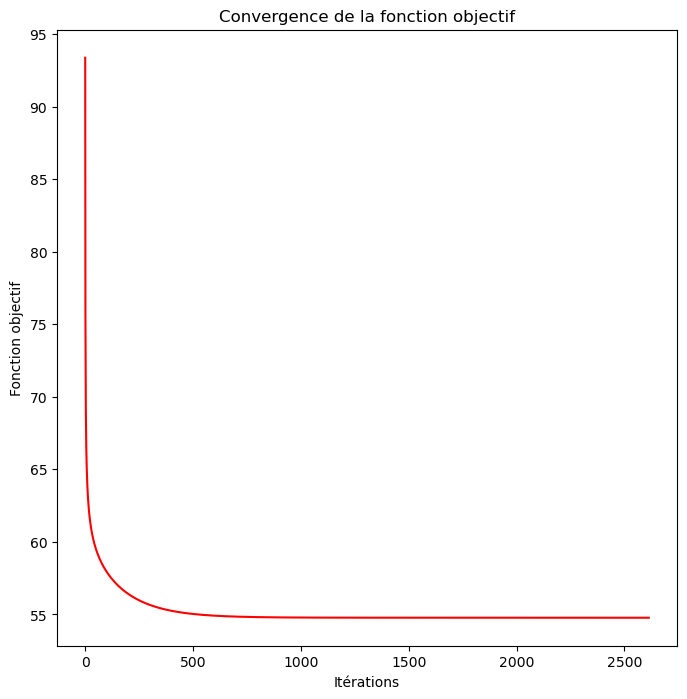

In [22]:
# Algorithme du gradient projeté 

# Calcul de la matrice BB^* pour l'opérateur de projection
BT=B.T
BBT=B@BT

# Initialisation
x_init=np.zeros(N)
y_init=np.zeros(M)
x=x_init.copy()
x_old=x_init.copy()
y=y_init.copy()
xtab=[]
ftab=[]
Ctab=[]

# Choix des paramètres
pas=0.0002
maxiter=3000
tol=1.e-6
    
xtab.append(x) # on ajoute x à la liste xtab
    
it=0 # compteur d'itération
    
while((it==0) or (it<maxiter and Ctab[-1]>tol)):

        x_old=x
        x=x-pas*(A_Lap@x-b)
        y=c-B@x
        y=spsolve(BBT, y, use_umfpack=True)
        x=x + BT@y

        
        xtab.append(x)
        ftab.append(J_Lap(x))
        Ctab.append(np.linalg.norm(x-x_old))
        
        it=it+1
    
# booléen pour indiquer la convergence
if(it==maxiter):
        conv = False
else:
        conv = True

print('=================================')
print('Algorithme du gradient projeté')
print('Convergence =',conv)
print('Nombre d itérations = ',np.shape(xtab)[0]-1)
#print('Erreur = ',Ctab[-1])

plt.figure(figsize=(8,8))
plt.plot(ftab,'-r')
plt.title('Convergence de la fonction objectif')
plt.xlabel('Itérations')
plt.ylabel('Fonction objectif')
plt.show()

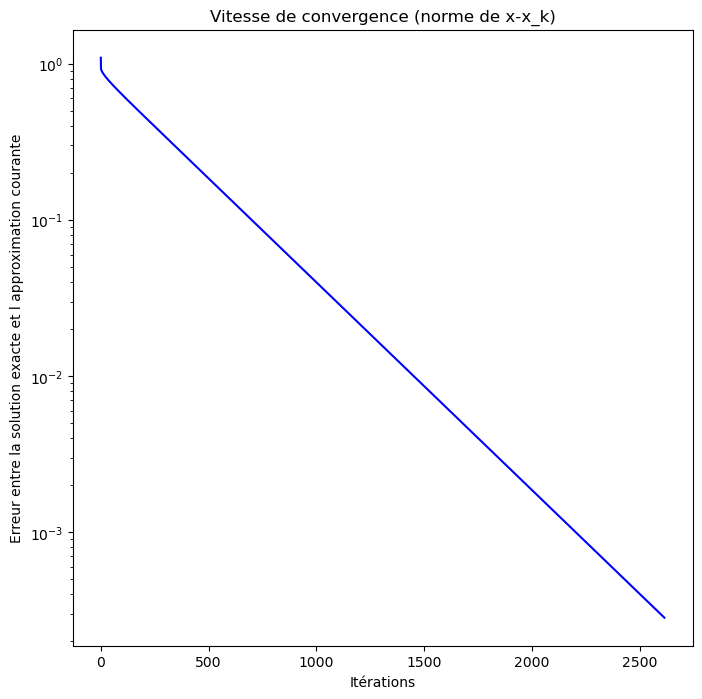

In [23]:
plt.figure(figsize=(8,8))
plt.semilogy(np.linalg.norm(xtab-x_sol,axis=1),'-b')
plt.title('Vitesse de convergence (norme de x-x_k)')
plt.xlabel('Itérations')
plt.ylabel('Erreur entre la solution exacte et l approximation courante')
plt.show()

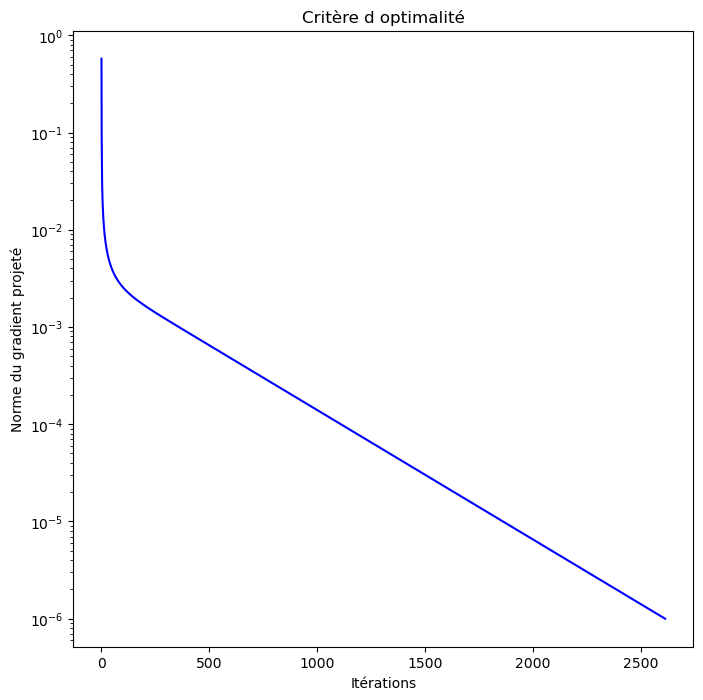

In [24]:
plt.figure(figsize=(8,8))
plt.semilogy(Ctab,'-b')
plt.title('Critère d optimalité')
plt.xlabel('Itérations')
plt.ylabel('Norme du gradient projeté')
plt.show()

## Exercice : Algorithme d'Uzawa

Le but de cet exercice est de tester l'algorithme d'Uzawa sur l'exemple précédent.


### Construction du Lagrangien

On définit le Lagrangien pour $(x,p)\in\mathbb R^N \times \mathbb R^M$ 
$$
{\mathcal L}(x,p) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle + \langle p, B x - c \rangle . 
$$

L'algorithme d'Uzawa construit une double suite $x_k\in\mathbb R^N$ et $p_k\in\mathbb R^M$, définie comme suit :
on initialise avec $p^0\in\mathbb R^M$ et on itère, pour $k\geq0$, 

\begin{equation}
\left\{
\begin{array}{l}
{\cal L}(x^k,p^k)=\inf_{x\in \mathbb R^N} {\cal L}(x,p^k)\;,\\[0.2cm]
p^{k+1}=p^k+\mu (Bx^k-c)\;,
\end{array}
\right.
\end{equation}

où $\mu >0$ est le pas de l'algorithme.

Un calcul facile montre que 
$$
x^k = A^{-1} (b - B^* p^k ) .
$$

In [25]:
def uzawa(f,sec_mbr,contr_B,p_init,pas,tol=1e-06,maxiter=100):
    
    # initialisation
    p=p_init.copy()
    xtab=[]
    ptab=[]
    ftab=[]
    Ctab=[]
    
    ptab.append(p) # on ajoute p à la liste ptab
    
    it=0 # compteur d'itération
    
    while((it==0) or (it<maxiter and Ctab[-1]>tol)):
        # le critère de convergence est que le gradient de la fonction duale tende vers zéro
    
        x=spsolve(A_Lap.tocsc(), sec_mbr(p), use_umfpack=True)
        p=p+pas*contr_B(x)        
        
        xtab.append(x)
        ptab.append(p)
        ftab.append(f(x))
        Ctab.append(np.linalg.norm(contr_B(x)))
        
        it=it+1
    
    # booléen pour indiquer la convergence
    if(it==maxiter):
        conv = False
    else:
        conv = True
    
    return xtab, ptab, ftab, Ctab, conv

Algorithme de Uzawa
Violation de la contrainte =  9.998403225980638e-07
Convergence = True
Nombre d itérations =  5915


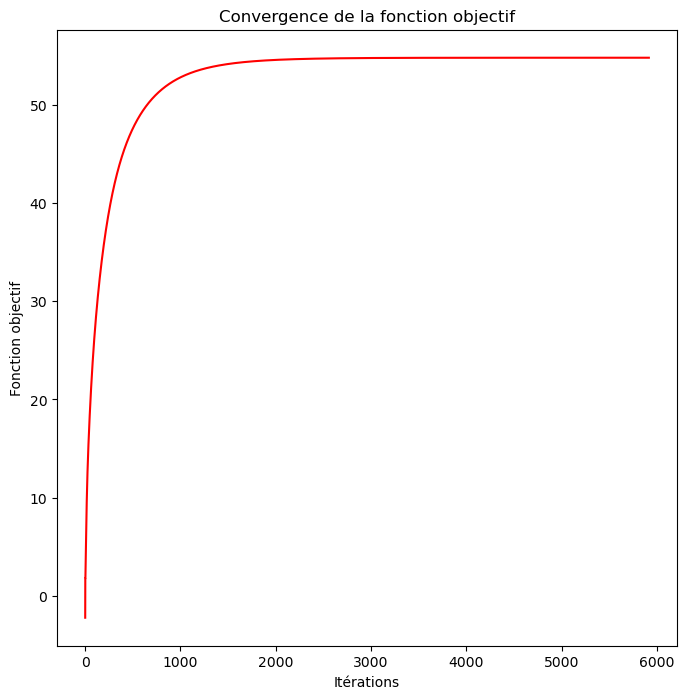

In [26]:
# Initialisation du multiplicateur de Lagrange
p_init=np.zeros(M)
pas=2.

print('=================================')
print('Algorithme de Uzawa')
x_Uzawa, p_Uzawa, f_Uzawa, C_Uzawa, conv_Uzawa = uzawa(J_Lap,sec_mbr,contr_B,p_init,pas,1e-6,20000)
print('Violation de la contrainte = ',C_Uzawa[-1])
print('Convergence =',conv_Uzawa)
print('Nombre d itérations = ',np.shape(x_Uzawa)[0]-1)

plt.figure(figsize=(8,8))
plt.plot(f_Uzawa,'-r')
plt.title('Convergence de la fonction objectif')
plt.xlabel('Itérations')
plt.ylabel('Fonction objectif')
plt.show()


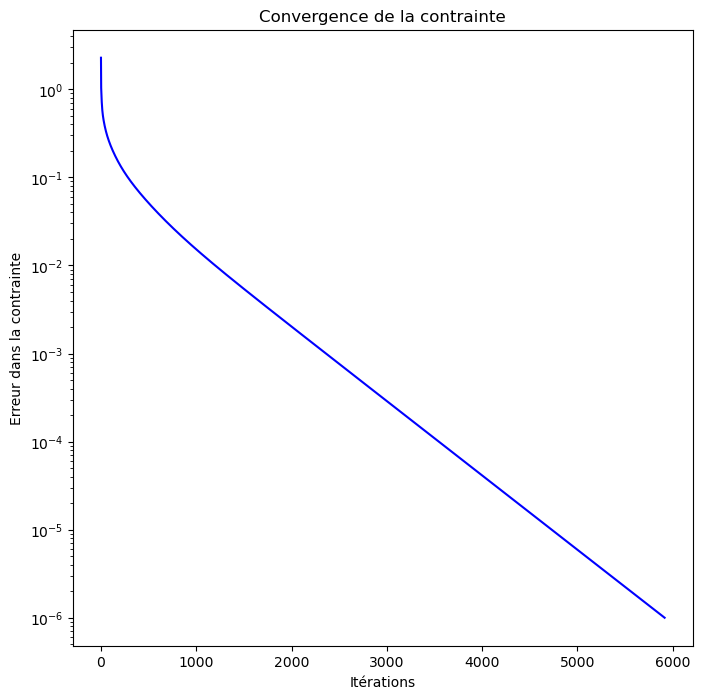

In [27]:
plt.figure(figsize=(8,8))
plt.semilogy(C_Uzawa,'-b')
plt.title('Convergence de la contrainte')
plt.xlabel('Itérations')
plt.ylabel('Erreur dans la contrainte')
plt.show()


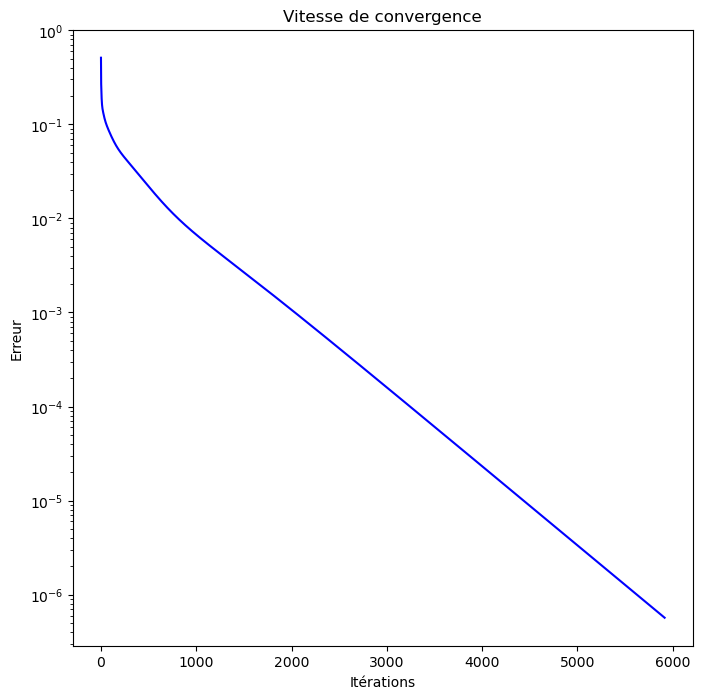

In [28]:
plt.figure(figsize=(8,8))
plt.semilogy(np.linalg.norm(x_Uzawa-x_sol,axis=1),'-b')
plt.title('Vitesse de convergence')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()

# Exercice : Méthode de pénalisation

Le but de cet exercice est de tester la méthode de pénalisation sur le problème précédent.

Pour $\epsilon>0$ petit, on minimise la fonctionnelle quadratique $J_\epsilon : \mathbb R^N \rightarrow \mathbb R$ telle que  
$$ 
J_\epsilon(x) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle + \frac{1}{2\epsilon} \|Bx-c\|^2.
$$

On peut calculer la solution exacte $x_\epsilon$ en écrivant la condition d'optimalité
$$
\left( A + \frac{1}{\epsilon} B^*B \right) x_\epsilon = b + \frac{1}{\epsilon} B^*c .
$$

On cherche ici à observer l'influence du paramètre $\epsilon$ dans la pénalisation.


nombre de valeurs testées = 17


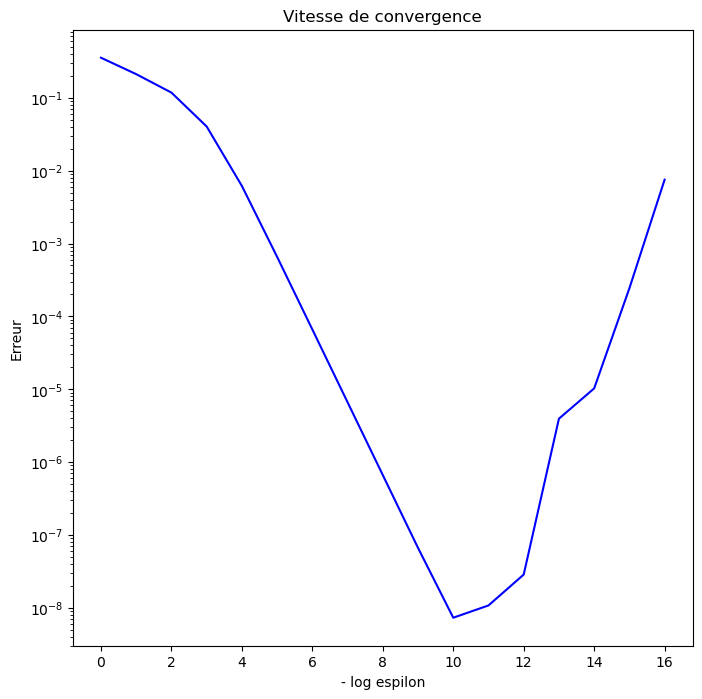

In [29]:
# Méthode de pénalisation

xtab=[]
ftab=[]
Ctab=[]

ip=0 # puissance de pénalisation
    
while((ip==0) or (ip<17)):
    # on teste des valeurs de plus en plus petites de epsilon
    epsilon=(0.1)**ip
    # calcul du second membre
    d=b+(1/epsilon)*np.transpose(B)*c

    # B^*B
    D=B.T@B

    # A+B^*B/epsilon
    E = A_Lap +(1/epsilon)*D

    #x_epsilon=np.linalg.solve(E,d)
    x_epsilon=spsolve(E.tocsc(), d, use_umfpack=True) 
    xtab.append(x_epsilon)
    ftab.append(J_Lap(x_epsilon))
    Ctab.append(np.linalg.norm(contr_B(x_epsilon)))
        
    ip=ip+1
        


# vérification des résultats
print('nombre de valeurs testées =',ip)
#f_epsilon = J_Lap(x_epsilon)
#print('J(x_epsilon) =',f_epsilon)
#print('Erreur dans la contrainte pour x_epsilon = ',np.linalg.norm(contr_B(x_epsilon)))
#print('Erreur entre x_epsilon et x_sol = ',np.linalg.norm(x_epsilon-x_sol))

plt.figure(figsize=(8,8))
plt.semilogy(np.linalg.norm(xtab-x_sol,axis=1),'-b')
plt.title('Vitesse de convergence')
plt.xlabel('- log espilon')
plt.ylabel('Erreur')
plt.show()

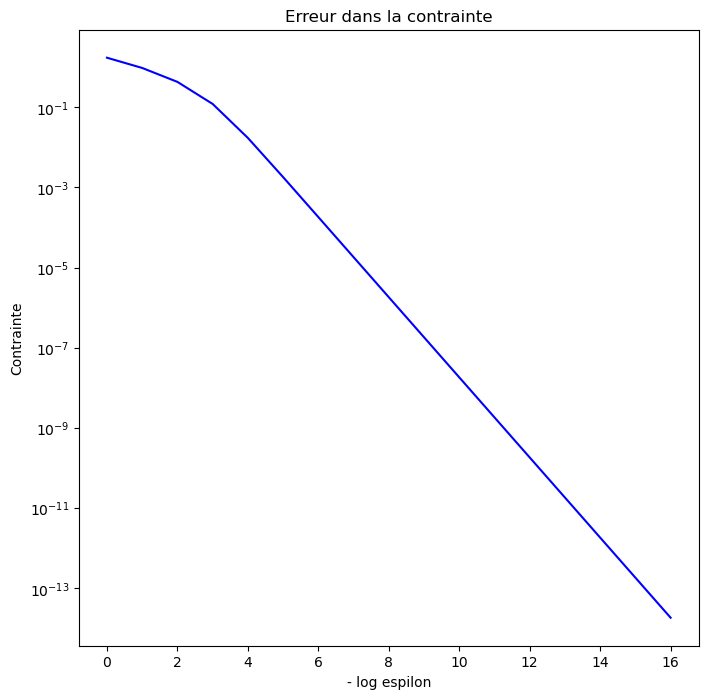

In [30]:
plt.figure(figsize=(8,8))
plt.semilogy(Ctab,'-b')
plt.title('Erreur dans la contrainte')
plt.xlabel('- log espilon')
plt.ylabel('Contrainte')
plt.show()

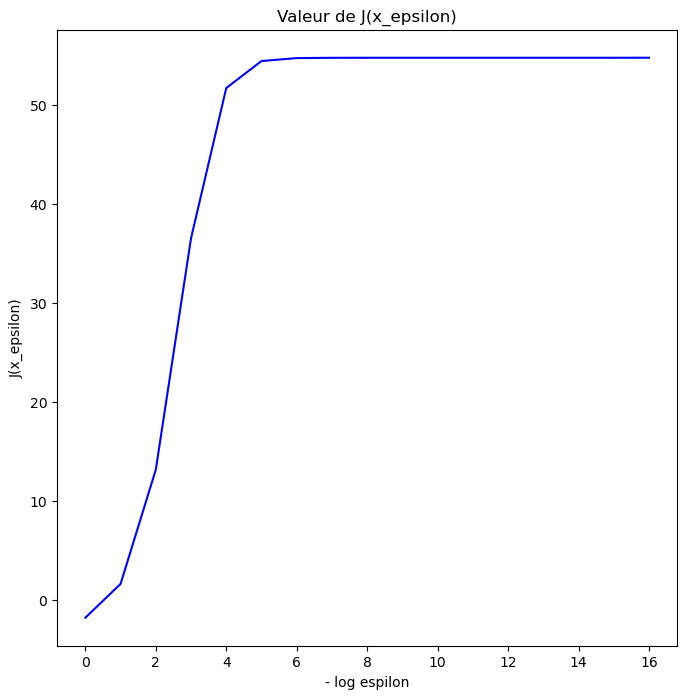

In [31]:
plt.figure(figsize=(8,8))
plt.plot(ftab,'-b')
plt.title('Valeur de J(x_epsilon)')
plt.xlabel('- log espilon')
plt.ylabel('J(x_epsilon)')
plt.show()

## Exercice : Algorithme du Lagrangien augmenté

Soit $\nu>0$. On définit le Lagrangien augmenté pour $(x,p)\in\mathbb R^N \times \mathbb R^M$ 
$$
{\mathcal L}_\nu(x,p) = \frac12 \langle Ax,x\rangle - \langle b,x\rangle + \langle p, B x - c \rangle + \frac\nu2 \|Bx-c\|^2.
$$

L'algorithme du Lagrangien augmenté construit une double suite $x_k\in\mathbb R^N$ et $p_k\in\mathbb R^M$, définie comme suit :
on initialise avec $p^0\in\mathbb R^M$ et on itère, pour $k\geq0$, 

\begin{equation}
\left\{
\begin{array}{l}
{\cal L}_\nu(x^k,p^k)=\inf_{x\in \mathbb R^N} {\cal L}_\nu(x,p^k)\;,\\[0.2cm]
p^{k+1}=p^k+\nu (Bx^k-c)\;.
\end{array}
\right.
\end{equation}


Un calcul facile montre que 
$$
x^k = \left( A + \nu B^*B \right)^{-1} (b - B^* p^k + \nu B^*c ) .
$$


In [32]:
# Définition du second membre qui permet de calculer x^k
def sec_mbr2(p,nu):
    return b - np.transpose(B)*(p - nu*c)

def augment(f,sec_mbr2,contr_B,p_init,nu=0.1,tol=1e-06,maxiter=100):
    
    # initialisation
    p=p_init.copy()
    xtab=[]
    ptab=[]
    ftab=[]
    Ctab=[]
    
    ptab.append(p) # on ajoute p à la liste ptab
    
    # B^*B
    D=B.T@B

    # A+nu*B^*B
    E = A_Lap + nu*D

    it=0 # compteur d'itération
    
    while((it==0) or (it<maxiter and Ctab[-1]>tol)):

        x=spsolve(E.tocsc(), sec_mbr2(p,nu), use_umfpack=True)
        p=p+nu*contr_B(x)
        
        xtab.append(x)
        ptab.append(p)
        ftab.append(f(x))
        Ctab.append(np.linalg.norm(contr_B(x)))
        
        it=it+1
    
    # booléen pour indiquer la convergence
    if(it==maxiter):
        conv = False
    else:
        conv = True
    
    return xtab, ptab, ftab, Ctab, conv

Algorithme du Lagrangien augmenté
Violation de la contrainte =  9.173739093801081e-07
Convergence = True
Nombre d itérations =  124


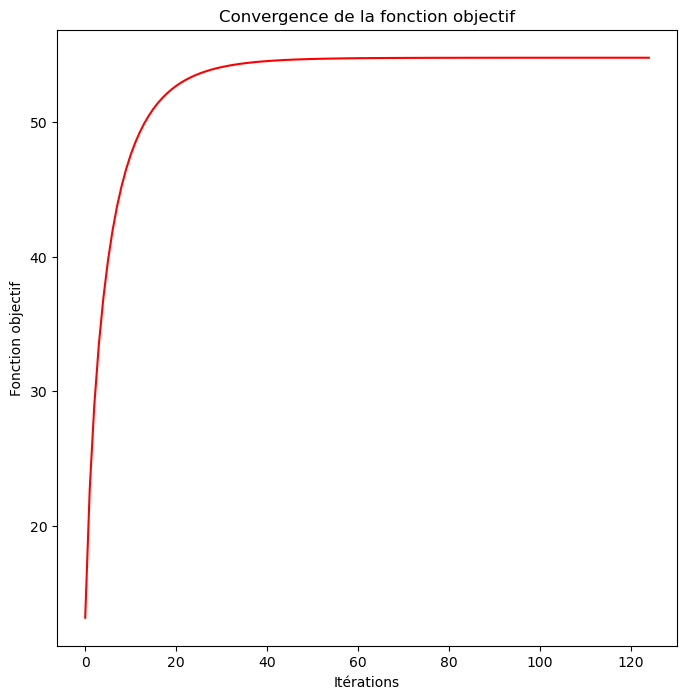

In [33]:
print('=================================')
print('Algorithme du Lagrangien augmenté')
x_augment, p_augment, f_augment, C_augment, conv_augment = augment(J_Lap,sec_mbr2,contr_B,p_init,100.,1e-6,20000)
print('Violation de la contrainte = ',C_augment[-1])
print('Convergence =',conv_augment)
print('Nombre d itérations = ',np.shape(x_augment)[0]-1)

plt.figure(figsize=(8,8))
plt.plot(f_augment,'-r')
plt.title('Convergence de la fonction objectif')
plt.xlabel('Itérations')
plt.ylabel('Fonction objectif')
plt.show()


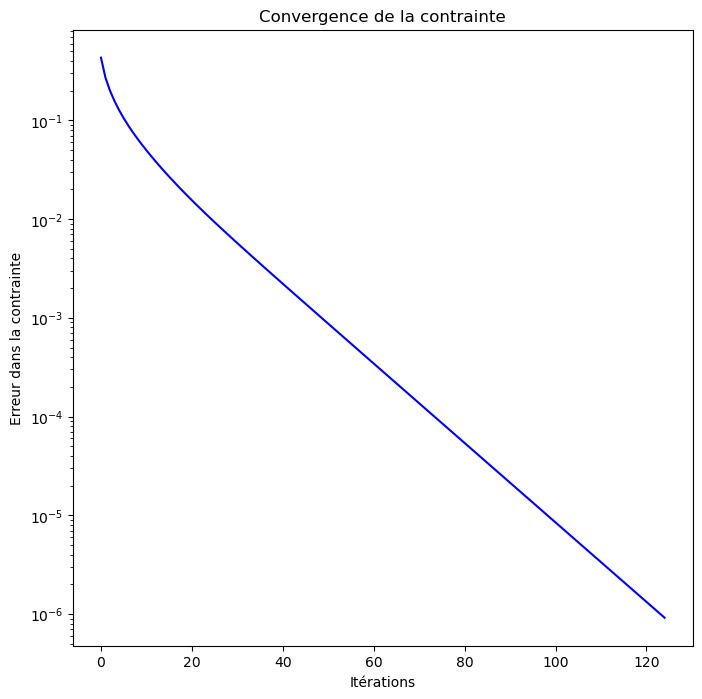

In [34]:
plt.figure(figsize=(8,8))
plt.semilogy(C_augment,'-b')
plt.title('Convergence de la contrainte')
plt.xlabel('Itérations')
plt.ylabel('Erreur dans la contrainte')
plt.show()


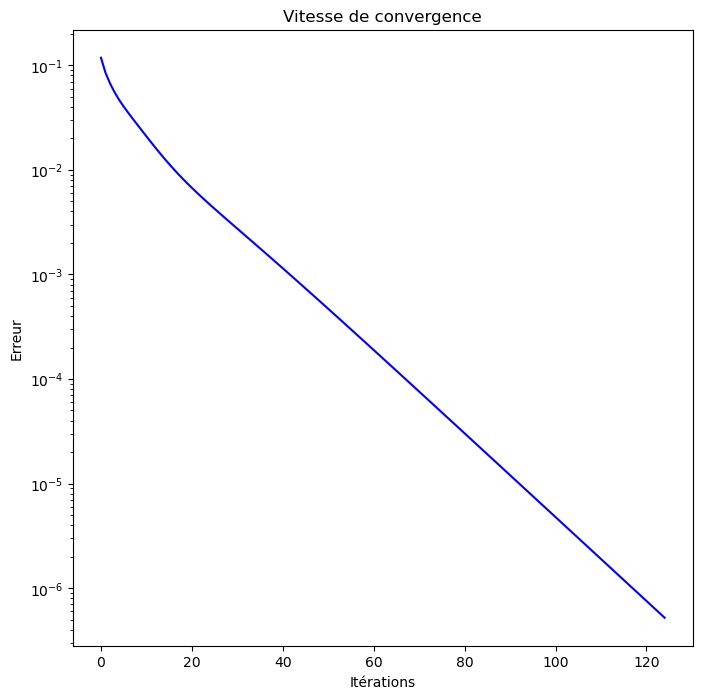

In [35]:
plt.figure(figsize=(8,8))
plt.semilogy(np.linalg.norm(x_augment-x_sol,axis=1),'-b')
plt.title('Vitesse de convergence')
plt.xlabel('Itérations')
plt.ylabel('Erreur')
plt.show()